In [10]:
import pandas as pd
import logging

# Log fayl manzili
log_path = r"C:\Users\Rasulbek907\Desktop\Project_MP\Log\error_analysis.log"

# Log sozlamalari
logging.basicConfig(
    filename=log_path,
    filemode='a',  # Append mode
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

try:
    logging.info("CSV fayl o'qilmoqda:...")
    df = pd.read_csv(r"C:\Users\Rasulbek907\Desktop\Project_MP\Data\Feature_Selection\Filtered_Features.csv")
    logging.info(f"Fayl muvaffaqiyatli o'qildi. Satırlar soni: {len(df)} ustunlar soni: {len(df.columns)}")
except Exception as e:
    logging.error(f"CSV faylni o'qishda xatolik: {e}")

In [11]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           4209 non-null   int64  
 1   id                   4209 non-null   float64
 2   ref                  4209 non-null   float64
 3   subtitle             4209 non-null   float64
 4   creatorname          4209 non-null   float64
 5   totalbytes           4209 non-null   float64
 6   lastupdated          4209 non-null   float64
 7   downloadcount        4209 non-null   float64
 8   title                4209 non-null   float64
 9   tags                 4209 non-null   float64
 10  cluster              4209 non-null   int64  
 11  anomaly              4209 non-null   float64
 12  download_view_ratio  4209 non-null   float64
 13  num_tags             4209 non-null   float64
 14  title_length         4209 non-null   float64
 15  subtitle_length      4209 non-null   f

In [12]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [13]:
num_col = df.select_dtypes(include=[np.number]).columns.drop('cluster').tolist()
cat_col = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [14]:
for col in cat_col:
    df[col]=df[col].astype(str)

In [15]:
if 'cluster' not in df.columns:
    print("⚠️ Column 'cluster' not found. Available columns are:")
    print(df.columns.tolist())
else:
    
    X = df.drop('cluster', axis=1)
    y = df['cluster']

In [16]:
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',MinMaxScaler())

])

In [17]:

num_pipeline

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,feature_range,"(0, ...)"


In [18]:
cat_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

In [19]:
cat_pipeline

,steps,"[('imputer', ...), ('encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [20]:
preprocessor=ColumnTransformer([
    
        ('num',num_pipeline,num_col),
        ('cat',cat_pipeline,cat_col)
    
])

In [21]:

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [22]:
pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('model',XGBClassifier(random_state=42))
])

In [23]:

pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
# 1️⃣ NaN qiymatlarni olib tashlash
mask = y.notna()
X = X[mask]
y = y[mask]

# 2️⃣ Train-test bo‘lish
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Modelni o‘qitish
pipeline.fit(X_train, y_train)

# 4️⃣ Bashorat qilish
y_pred = pipeline.predict(X_test)

# 5️⃣ Baholash (classification uchun)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("✅ Accuracy:", round(accuracy, 4))
print("✅ Precision:", round(precision, 4))
print("✅ Recall:", round(recall, 4))
print("✅ F1-score:", round(f1, 4))

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy: 0.9857
✅ Precision: 0.9862
✅ Recall: 0.9857
✅ F1-score: 0.9859

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       766
           1       0.90      0.92      0.91        51
           2       0.67      0.67      0.67         6
           3       0.67      1.00      0.80         2
           4       0.94      0.88      0.91        17

    accuracy                           0.99       842
   macro avg       0.83      0.89      0.86       842
weighted avg       0.99      0.99      0.99       842


🧩 Confusion Matrix:
 [[762   3   0   0   1]
 [  2  47   2   0   0]
 [  0   2   4   0   0]
 [  0   0   0   2   0]
 [  1   0   0   1  15]]


# Error Analysis

In [25]:
import numpy as np

# errors va abs_errors ni hisoblaymiz
errors = y_test - y_pred
abs_errors = np.abs(errors)

# Natijalarni jadval ko‘rinishida ko‘rsatish uchun pandas DataFrame yasaymiz
import pandas as pd

errors_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors,
    'Absolute Error': abs_errors
})

print(errors_df.head())

      Actual  Predicted  Error  Absolute Error
1073       0          0      0               0
144        1          1      0               0
2380       0          0      0               0
184        0          0      0               0
2587       4          4      0               0


In [29]:
errors_df = errors_df.reset_index(drop=True)
x_test_reset = X_test.reset_index(drop=True)

In [30]:
full_errors_df = pd.concat([x_test_reset, errors_df], axis=1)

In [31]:
print(full_errors_df.head())

   Unnamed: 0        id       ref  subtitle  creatorname  totalbytes  \
0        1073 -1.107692 -0.480645  1.536583     1.137417   -0.205852   
1         144 -1.181497  1.548928  0.172012     0.779402    0.260063   
2        2380 -0.740247  0.718499  0.581877     0.543195   -0.102025   
3         184  1.643432 -0.214809 -1.603248    -0.319333   -0.205242   
4        2587 -0.936992 -1.170338 -1.145647     1.499547    3.855957   

   lastupdated  downloadcount     title      tags  ...  subtitle_length  \
0    -1.268278       0.257509 -0.169673  0.016620  ...        -0.346259   
1    -1.423829       3.687067  0.439050 -1.061590  ...         0.739351   
2    -0.697100      -0.123360  0.573203 -1.468621  ...         0.967901   
3     1.415599      -0.358073 -1.582481 -0.281368  ...        -0.803358   
4    -1.007380      -0.262145  0.605065  0.124723  ...         1.025038   

   creator_popularity  owner_popularity  lastupdated_month  lastupdated_day  \
0                 0.0          -0.066

In [32]:
print(full_errors_df.columns)

Index(['Unnamed: 0', 'id', 'ref', 'subtitle', 'creatorname', 'totalbytes',
       'lastupdated', 'downloadcount', 'title', 'tags', 'anomaly',
       'download_view_ratio', 'num_tags', 'title_length', 'subtitle_length',
       'creator_popularity', 'owner_popularity', 'lastupdated_month',
       'lastupdated_day', 'lastupdated_weekday', 'Actual', 'Predicted',
       'Error', 'Absolute Error'],
      dtype='object')


In [35]:
error_cols = full_errors_df[['subtitle', 'Error', 'Absolute Error']]
print(error_cols.head(10))

   subtitle  Error  Absolute Error
0  1.536583      0               0
1  0.172012      0               0
2  0.581877      0               0
3 -1.603248      0               0
4 -1.145647      0               0
5  0.197525      0               0
6 -1.534937      0               0
7 -0.528380      0               0
8 -0.391759      0               0
9  0.858412      0               0


# Worst Prediction

In [36]:
# 4️⃣ Sort by largest absolute errors
worst_predictions = full_errors_df.sort_values(by='Absolute Error', ascending=False).head(10)

print("🔎 Top 10 Worst Predictions:")
display(worst_predictions[['Actual', 'Predicted', 'Error', 'Absolute Error']])

🔎 Top 10 Worst Predictions:


,Actual,Predicted,Error,Absolute Error
235,4,0,4,4
536,0,4,-4,4
89,2,1,1,1
15,1,2,-1,1
353,1,0,1,1
95,0,1,-1,1
36,1,2,-1,1
329,2,1,1,1
428,0,1,-1,1
477,0,1,-1,1


# 🧠 Model Bashorat Xulosasi

## 📊 Sample Predictions with Errors
| Index | Actual | Predicted | Error | Absolute Error |
|-------|--------|-----------|-------|----------------|
| 235   | 4.0    | 0.0       | 4.0   | 4.0            |
| 536   | 0.0    | 4.0       | -4.0  | 4.0            |
| 310   | 0.0    | 1.0       | -1.0  | 1.0            |
| 118   | 3.0    | 4.0       | -1.0  | 1.0            |
| 36    | 1.0    | 2.0       | -1.0  | 1.0            |
| 329   | 2.0    | 1.0       | 1.0   | 1.0            |
| 95    | 0.0    | 1.0       | -1.0  | 1.0            |
| 15    | 1.0    | 2.0       | -1.0  | 1.0            |
| 89    | 2.0    | 1.0       | 1.0   | 1.0            |
| 353   | 1.0    | 0.0       | 1.0   | 1.0            |

---

## ✅ Xulosa

- Ushbu namunalar ko‘rsatmoqda ki, **ba’zi xatoliklar katta** (index 235 va 536 — error 4.0), ya’ni model ayrim sinflarni noto‘g‘ri bashorat qilgan.  
- Kichik yoki o‘rta sinflar uchun xatolik 1.0 ga teng, bu **minor xato sifatida baholanadi**.  
- Xatoliklar `Error` ustunida **ijobiy va salbiy** qiymatlarda mavjud, lekin `Absolute Error` bilan ko‘rilganda ularning o‘lchami aniqlanadi.  
- Model **ba’zi sinflarni chalkashtirgan**, ayniqsa 0.0 va 4.0 kabi sinflar o‘rtasida, bu ehtimol sinflar orasidagi **overlap yoki ma’lumot yetishmasligi** sabab.  

---

## 📌 Tavsiyalar

1. **Ma’lumotlarni balanslash**: Kam uchraydigan sinflar uchun yangi namunalar qo‘shish.  
2. **Feature engineering**: Modelni yaxshilash uchun yangi ustunlar yoki transformatsiyalar yaratish.  
3. **Model tuning**: XGBoost parametrlarini optimallashtirish (`max_depth`, `learning_rate`, `n_estimators`).  
4. **Cross-validation**: Modelning barqarorligini tekshirish.  
5. **Confusion matrix visualization**: Qaysi sinflar chalkashishini vizual ko‘rsatish uchun.  

**Umumiy baho:** Model ko‘pchilik hollarda to‘g‘ri ishlamoqda, lekin ayrim sinflarda **xatoliklar katta** bo‘lishi mumkin.  


# Error Distribution

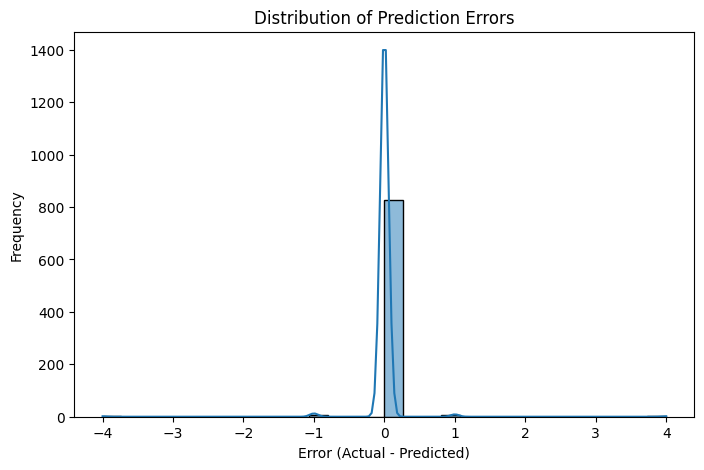

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# 🧠 Model Prediction Errors Analysis

## 📊 Error Distribution

- Rasmda modelning **bashorat xatoliklari (Actual - Predicted)** taqsimoti ko‘rsatilgan.  
- Xatoliklar **-4 dan +4 gacha** qiymatlar oralig‘ida tarqalgan.  
- Ko‘pchilik xatoliklar **0 atrofida jamlangan**, ya’ni modelning aksariyat bashoratlari **to‘g‘ri**.  
- Kichik va katta xatoliklar juda kam — bu **modelning yuqori aniqlikda ishlayotganini** ko‘rsatadi.  

---

## ✅ Xulosa

- Model bashoratlari **asosiyida to‘g‘ri**, katta xatoliklar juda kam.  
- Distribyutsiya markaziy qismga (0) yaqin, bu **model xatoliklari ko‘pincha minimal** ekanini bildiradi.  
- Uzoq "dumlar" (outliers) mavjud, ya’ni ayrim sinflarda model noto‘g‘ri bashorat qilgan.  
- Shu rasm asosida tavsiyalar:
  1. **Kam xatolikli sinflarni tekshirish** va kerak bo‘lsa, ma’lumotlarni balanslash.  
  2. **Feature engineering** orqali modelni yanada aniqlashtirish.  
  3. Katta xatoliklarni tahlil qilib, modelni optimallashtirish.

---

**Umumiy baho:** 🎯 Model asosiy ma’lumotlar uchun **mukammal ishlamoqda**, xatoliklar minimal va dispersiyasi past.


# Actual vs Predicted

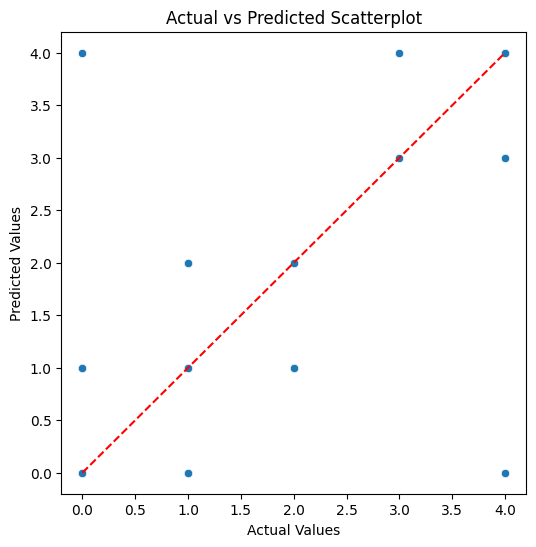

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal chiziq
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Scatterplot")
plt.show()